In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import numpy as np
import torch
torch.manual_seed(12)
torch.cuda.manual_seed(12)
torch.cuda.manual_seed_all

dtype = torch.float
device = torch.device("cuda:0")


In [2]:
import sys

In [3]:
sys.path.append('/u/wangnisn/devel/machine_learning_kinetics/ml_kinetics')

In [4]:
from mlk import learning

# Set up model

In [5]:
vortex = {'eqn_type':'vortex',
        'fcn':'exp(-1/2*(x-cos(t))**2-1/2*(y-sin(t))**2)',
        'domain':{'x':[-2,2],'y':[-2,2],'t':[0,2]},
        
        'err_vec':[0,0,0,1,-1,0,0]}

u_t,u_x,u_y,u,x,y = sympy.symbols('u_t u_x u_y u x y')

dictionary = (u_x,u_y,x*u_x,y*u_x,x*u_y,y*u_y,u)
vortex['dictionary'] = dictionary
pde = vortex
domain =pde['domain']
fcn = pde['fcn']
n_points = 50000
x = sympy.symbols([x for x in domain.keys()])
u_exact = sympy.lambdify(x,sympy.sympify(fcn),'numpy')
inputs = {}
for key in domain.keys():
    min_d = domain[key][0]
    max_d = domain[key][1]
    #iputs[key] = ((max_d-min_d)*torch.rand((n_points,1),device=device,dtype=dtype,requires_grad=True)+min_d)
    tt = np.random.uniform(min_d,max_d,(n_points,1))
    inputs[key] = torch.tensor(tt,device=device,dtype=dtype,requires_grad=True)
u_exact = sympy.lambdify(x,sympy.sympify(fcn),'numpy')
u = u_exact(*[i.detach().cpu() for i in inputs.values()])
pde = {}
u = u.type(dtype).to(device)
pde['inputs'] = inputs

In [6]:
%%time
params = {'n_epochs':10000,
          'alpha_pde_start':1,
           'alpha_pde_end':0.001,
           'alpha_l1':1e-5, 
          'warmup_nsteps':500,
          'linearRegInterval':5,
          'linearRegression':True,
          'width':50,
          'layers':8,
          'lr':0.002,
          'update_coef_in_dl':False,
          'logfile':'alpha_decrease.txt'}

model = learning(inputs=inputs, u=u, dictionary=dictionary,**params)


Epoch:    0,  Loss u: 1.381e-01, Loss pde: 9.824e-04, Loss_norm: 7.488e+00, Loss tot: 1.381e-01
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00    4.2288e-01  
Epoch:   50,  Loss u: 1.582e-02, Loss pde: 3.499e-01, Loss_norm: 7.488e+00, Loss tot: 1.582e-02
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00    4.2288e-01  
Epoch:  100,  Loss u: 2.466e-03, Loss pde: 9.053e-01, Loss_norm: 7.488e+00, Loss tot: 2.466e-03
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00    4.2288e-01  
Epoch:  150,  Loss u: 1.351e-03, Loss pde: 9.366e-01, Loss_norm: 7.488e+00, Loss tot: 1.351e-03
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00    4.2288e-01  
Epoch:  200,  Loss u: 9.331e-04, Loss pde: 9.299e-01, Loss_norm: 7.488e+00, Loss tot: 9.331e-04
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00  

Epoch: 2050,  Loss u: 1.484e-04, Loss pde: 7.163e-05, Loss_norm: 1.897e+00, Loss tot: 2.244e-04
  coefs:  6.0244e-02   -7.2201e-02    3.9086e-03    8.8131e-01   -8.7598e-01   -2.3229e-03   -1.3259e-03  
Epoch: 2100,  Loss u: 1.061e-04, Loss pde: 6.561e-05, Loss_norm: 1.943e+00, Loss tot: 1.774e-04
  coefs:  1.2398e-01   -1.9965e-02    3.5372e-05    8.8433e-01   -8.8871e-01   -1.9258e-02   -6.5983e-03  
Epoch: 2150,  Loss u: 7.493e-05, Loss pde: 5.738e-05, Loss_norm: 1.930e+00, Loss tot: 1.393e-04
  coefs:  9.2264e-02   -5.9864e-02   -1.3514e-03    8.8333e-01   -8.8500e-01   -6.0005e-03   -2.4431e-03  
Epoch: 2200,  Loss u: 1.513e-04, Loss pde: 8.042e-05, Loss_norm: 1.958e+00, Loss tot: 2.336e-04
  coefs:  7.1949e-02   -1.0446e-01   -3.8569e-03    8.8357e-01   -8.8009e-01    1.1992e-02    2.5299e-03  
Epoch: 2250,  Loss u: 3.866e-05, Loss pde: 4.941e-05, Loss_norm: 1.958e+00, Loss tot: 9.654e-05
  coefs:  1.0909e-01   -4.2640e-02   -3.1027e-03    8.9548e-01   -8.9832e-01   -6.5121e-03  

Epoch: 4100,  Loss u: 2.893e-05, Loss pde: 1.784e-05, Loss_norm: 1.987e+00, Loss tot: 5.934e-05
  coefs:  1.0638e-02   -3.0360e-02    4.1709e-04    9.7154e-01   -9.7021e-01    3.6250e-03    2.2908e-04  
Epoch: 4150,  Loss u: 1.211e-05, Loss pde: 1.509e-05, Loss_norm: 1.982e+00, Loss tot: 4.076e-05
  coefs:  1.6439e-02   -1.9250e-02   -0.0000e+00    9.7267e-01   -9.7149e-01    1.1150e-03    7.0003e-04  
Epoch: 4200,  Loss u: 7.920e-06, Loss pde: 1.435e-05, Loss_norm: 1.987e+00, Loss tot: 3.611e-05
  coefs:  2.1234e-02   -1.4267e-02    4.9817e-05    9.7541e-01   -9.7463e-01    9.9740e-04   -1.3360e-04  
Epoch: 4250,  Loss u: 1.177e-05, Loss pde: 1.420e-05, Loss_norm: 1.990e+00, Loss tot: 3.983e-05
  coefs:  2.2097e-02   -1.4944e-02   -7.9173e-04    9.7528e-01   -9.7563e-01    7.4922e-04   -3.1403e-05  
Epoch: 4300,  Loss u: 1.490e-05, Loss pde: 1.677e-05, Loss_norm: 1.982e+00, Loss tot: 4.429e-05
  coefs:  1.7062e-03   -1.6559e-02    1.6377e-03    9.8124e-01   -9.7986e-01    1.1918e-04  

Epoch: 6150,  Loss u: 1.310e-05, Loss pde: 1.021e-05, Loss_norm: 1.992e+00, Loss tot: 3.696e-05
  coefs:  1.0741e-02   -9.4009e-03    0.0000e+00    9.8476e-01   -9.8583e-01    1.1449e-03   -2.8668e-04  
Epoch: 6200,  Loss u: 1.810e-05, Loss pde: 1.489e-05, Loss_norm: 1.981e+00, Loss tot: 4.357e-05
  coefs:  7.5150e-03   -4.9490e-03   -2.6595e-04    9.8356e-01   -9.8239e-01   -1.8324e-03    3.8845e-04  
Epoch: 6250,  Loss u: 6.860e-06, Loss pde: 1.094e-05, Loss_norm: 1.990e+00, Loss tot: 3.087e-05
  coefs:  1.0935e-02   -6.5022e-03    1.7480e-04    9.8597e-01   -9.8588e-01   -9.7821e-05    1.1900e-04  
Epoch: 6300,  Loss u: 8.815e-06, Loss pde: 1.009e-05, Loss_norm: 1.995e+00, Loss tot: 3.250e-05
  coefs:  8.6569e-03   -8.3965e-03    5.6972e-04    9.8763e-01   -9.8818e-01    9.5574e-04    2.1997e-04  
Epoch: 6350,  Loss u: 9.504e-06, Loss pde: 1.156e-05, Loss_norm: 2.002e+00, Loss tot: 3.375e-05
  coefs:  1.1457e-02   -1.3337e-02   -1.7090e-03    9.8536e-01   -9.8821e-01    1.8977e-03  

Epoch: 8200,  Loss u: 2.782e-06, Loss pde: 9.586e-06, Loss_norm: 1.995e+00, Loss tot: 2.447e-05
  coefs:  5.7632e-03   -2.9633e-03    9.2328e-05    9.9304e-01   -9.9355e-01   -0.0000e+00    0.0000e+00  
Epoch: 8250,  Loss u: 4.806e-06, Loss pde: 1.023e-05, Loss_norm: 1.997e+00, Loss tot: 2.658e-05
  coefs:  7.2838e-03   -1.6631e-03    1.2943e-03    9.9356e-01   -9.9196e-01   -1.2118e-03   -1.4741e-04  
Epoch: 8300,  Loss u: 3.430e-06, Loss pde: 9.597e-06, Loss_norm: 1.997e+00, Loss tot: 2.504e-05
  coefs:  5.1351e-03   -6.3015e-03    0.0000e+00    9.9212e-01   -9.9275e-01    9.3525e-04    1.0501e-04  
Epoch: 8350,  Loss u: 8.528e-06, Loss pde: 1.036e-05, Loss_norm: 1.997e+00, Loss tot: 3.021e-05
  coefs:  8.5129e-03   -0.0000e+00    4.9216e-04    9.9359e-01   -9.9284e-01   -1.3117e-03   -6.5198e-05  
Epoch: 8400,  Loss u: 2.726e-06, Loss pde: 9.606e-06, Loss_norm: 1.996e+00, Loss tot: 2.423e-05
  coefs:  5.5670e-03   -4.3355e-03    0.0000e+00    9.9275e-01   -9.9327e-01    3.1360e-04  

In [7]:
log = pd.read_csv('alpha_decrease.txt')

In [8]:
log

,Epoch,Loss_u,Loss_pde,Loss_l1,Loss_tot,p0,p1,p2,p3,p4,p5,p6
0,0,0.138140,0.000982,7.4879,0.138140,-0.563040,-2.897000,0.143700,-0.62471,-1.48660,1.350000,0.422880
1,1,0.130960,0.000563,7.4879,0.130960,-0.563040,-2.897000,0.143700,-0.62471,-1.48660,1.350000,0.422880
2,2,0.119430,0.000707,7.4879,0.119430,-0.563040,-2.897000,0.143700,-0.62471,-1.48660,1.350000,0.422880
3,3,0.099913,0.004417,7.4879,0.099913,-0.563040,-2.897000,0.143700,-0.62471,-1.48660,1.350000,0.422880
4,4,0.073070,0.022871,7.4879,0.073070,-0.563040,-2.897000,0.143700,-0.62471,-1.48660,1.350000,0.422880
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0.000002,0.000014,1.9979,0.000022,0.002407,-0.000973,0.000287,0.99642,-0.99755,-0.000182,0.000129
9996,9996,0.000002,0.000014,1.9979,0.000022,0.002407,-0.000973,0.000287,0.99642,-0.99755,-0.000182,0.000129
9997,9997,0.000002,0.000014,1.9979,0.000022,0.002407,-0.000973,0.000287,0.99642,-0.99755,-0.000182,0.000129
9998,9998,0.000002,0.000014,1.9979,0.000022,0.002407,-0.000973,0.000287,0.99642,-0.99755,-0.000182,0.000129


(-1.0, 1.0)

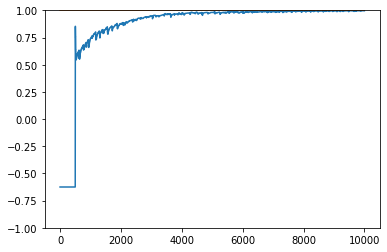

In [9]:
plt.plot(log['Epoch'].values, log['p3'].values)
plt.plot([0,10000],[1,1])
plt.ylim(-1,1)

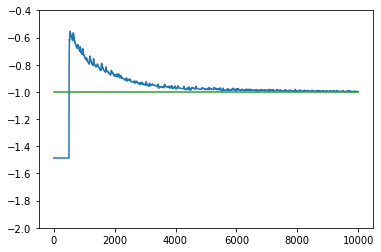

In [10]:
plt.plot(log['Epoch'], log['p4'])
plt.plot([0,10000],[1,1])
plt.ylim(-2,-0.4)
plt.plot([0,10000],[-1,-1])

(0.96, 1.0)

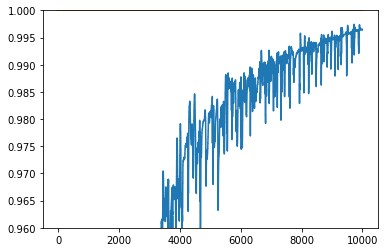

In [11]:
plt.plot(log['Epoch'].values, log['p3'].values)
plt.plot([0,10000],[1,1])
plt.ylim(0.96,1)

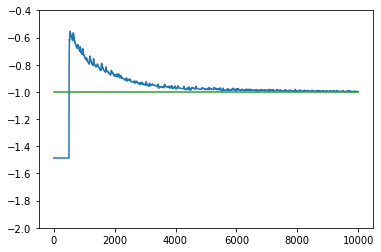

In [12]:
plt.plot(log['Epoch'], log['p4'])
plt.plot([0,10000],[1,1])
plt.ylim(-2,-0.4)
plt.plot([0,10000],[-1,-1])

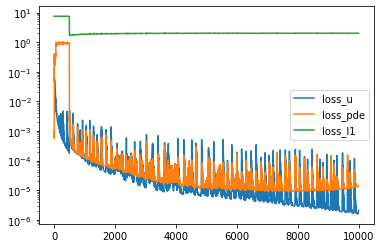

In [13]:
plt.semilogy(log['Epoch'], log['Loss_u'], label='loss_u')
plt.semilogy(log['Epoch'], log['Loss_pde'], label='loss_pde')
plt.semilogy(log['Epoch'], log['Loss_l1'], label='loss_l1')
plt.legend()

In [10]:
t_mesh = dt*np.arange(nsteps)
x_mesh = dx*np.arange(nx)
y_mesh = dy*np.arange(ny)
t_mesh, x_mesh,y_mesh = np.meshgrid(t_mesh, x_mesh, y_mesh,indexing='ij')
t_mesh = np.reshape(t_mesh, (-1,1))
x_mesh = np.reshape(x_mesh, (-1,1))
y_mesh = np.reshape(y_mesh, (-1,1))
x_mesh /= x_max
y_mesh /= y_max
t_mesh /= t_max
prediction = model(torch.cat([torch.tensor(x_mesh), torch.tensor(y_mesh), torch.tensor(t_mesh)],dim=1).double().cuda(0))